## Pregunta al Profeta ¿cuánto agua necesitaré mañana?

Algunas grandes empresas tecnológicas como Facebook han liberado algoritmos para su uso en otros sectores. En el código se utiliza Prophet, que usa solamente datos extraíbles de la marca de tiempo para predecir la evolución del valor de una serie temporal.

Lo aplicaremos a la estimación de las necesidades diarias de producción de caudal en una planta potabilizadora de agua. Aunque pueda parecer que prescindir del análisis de otras variables del entorno (presión, temperatura, precipitaciones, humedad, etc...) es una temeridad, la potencia del algoritmo y la existencia de un conjunto de datos suficientemente amplio, demuestra que puede lograr aproximaciones aceptables al menos para valores medios y al margen de variaciones en la estrategia de producción o de incidentes.

In [1]:
### #####################
### Q_ETAP - Prophet
### Jose Maria de Cuenca
### #####################


# Cargo libreriasgenerales
import time # Cronometro para el modelo
import numpy as np # Algebra de matrices
import pandas as pd # Procesado de datos

# Cargo funcion para graficos
from matplotlib import pyplot as plt # Graficos


## Carga de datos

In [2]:
# Cargo dataset con datos de caudales diariamente suministrados entre 2000 y 2019
df = pd.read_csv("Q_ETAP.csv")

# Muestro primeros registros del dataset
df.head(7)

,Fecha,Qt_SUM_VA
0,2000-01-01,62728
1,2000-01-02,67306
2,2000-01-03,66848
3,2000-01-04,67294
4,2000-01-05,68562
5,2000-01-06,68112
6,2000-01-07,68142


In [3]:
# Compruebo los tipos de datos
print("Data Types:", df.dtypes)

Data Types: Fecha        object
Qt_SUM_VA     int64
dtype: object


In [4]:
# Compruebo que la fecha en csv se guarda como objeto, debe cambiarse
# Reescribo la columna de fecha con su contenido en formato de fecha (entro como object desde el csv)
df['date'] = pd.to_datetime(df['Fecha'])

# El tipo de dato DtetimeIndex permite a Pandas interpretar el dataframe como una serie temporal.

# Compruebo el cambio
print("Data Types:", df.dtypes)

Data Types: Fecha                object
Qt_SUM_VA             int64
date         datetime64[ns]
dtype: object


## Creación de modelo de predicciones con Prophet

In [5]:
# Creo un nuevo dataset con los nombres de las columnas que necesita Prophet para fecha (ds) y datos (y)

# Defino diccionario para extraccion de las columnas
dict_pro_df={'ds':df['Fecha'],'y':df['Qt_SUM_VA']}

# Creo el nuevo dataframe pandas
pro_df=pd.DataFrame(data=dict_pro_df)

In [6]:
# Muestro resultados del dataset adaptado a Prophet
pro_df.head()

,ds,y
0,2000-01-01,62728
1,2000-01-02,67306
2,2000-01-03,66848
3,2000-01-04,67294
4,2000-01-05,68562


In [7]:
# Cargo la función y creo un modelo de prediccion con Prophet
from fbprophet import Prophet
mod_prophet = Prophet()

# Incorporo el calendario de festivos nacionales al modelo
mod_prophet.add_country_holidays(country_name='ES')

# Solo podra entrenarse una vez durante la ejecucion del cuaderno, si se necesiran varios hay que definir otros

In [8]:
# Inicio cronometro
start_time = time.time()

# Entreno el modelo de predicción Prophet
mod_prophet.fit(pro_df)
# No uso estacionalidad diaria porque son valores diarios. Prophet lo detecta y avisa.
# Si los datos fueran mensuales, desactivaria automaticamente la estacionalidad semanal.

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del modelo Prophet tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


El entrenamiento del modelo Prophet tarda:  10.89 segundos ( 0.2 minutos)


In [10]:
# Después de entrenar tambien podemos mostrar los festivos haciendo
mod_prophet.train_holiday_names

0                          Año nuevo
1                 Epifanía del Señor
2                      Viernes Santo
3                 Día del Trabajador
4              Asunción de la Virgen
5               Día de la Hispanidad
6                   Todos los Santos
7    Día de la constitución Española
8           La Inmaculada Concepción
9                            Navidad
dtype: object

In [11]:
# Defino un marco de datos para los 90 dias siguientes al ultimo registro
# Es un dataframe con el campo de fechas del conjunto inicial, prolongado hasta la prediccion (90 días)
future = mod_prophet.make_future_dataframe(periods = 90, freq='D')

# Por ejemplo, si datos horarios y predicciones a 3 dias la sintaxis sería:
# future = mod_prophet.make_future_dataframe(periods = 23*3, freq='H')

# Muestro los valores del ultimo registro del marco de datos
print(future.iloc[-1]);

ds   2020-03-30
Name: 7394, dtype: datetime64[ns]


In [12]:
# Inicio cronometro
start_time = time.time()

# Realizo las predicciones con el modelo de prediccion para el marco de datos
forecast = mod_prophet.predict(future)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La predicción con el modelo Prophet tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")


La predicción con el modelo Prophet tarda:  3.22 segundos ( 0.1 minutos)


In [13]:
# Muestro los ultimos registros de la tabla generada con el modelo predictivo
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen,Asunción de la Virgen_lower,Asunción de la Virgen_upper,Año nuevo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7390,2020-03-26,78692.372169,63505.066780,87996.600935,78668.455054,78706.573061,0.0,0.0,0.0,0.0,...,2243.806105,2243.806105,2243.806105,-5786.309955,-5786.309955,-5786.309955,0.0,0.0,0.0,75149.868319
7391,2020-03-27,78697.979645,65850.163205,89475.380664,78672.632105,78712.778722,0.0,0.0,0.0,0.0,...,5257.682157,5257.682157,5257.682157,-5699.239113,-5699.239113,-5699.239113,0.0,0.0,0.0,78256.422689
7392,2020-03-28,78703.587122,55510.773305,79642.583071,78677.567282,78718.801713,0.0,0.0,0.0,0.0,...,-5231.920413,-5231.920413,-5231.920413,-5600.504705,-5600.504705,-5600.504705,0.0,0.0,0.0,67871.162004
7393,2020-03-29,78709.194598,53247.495821,77401.882509,78682.226802,78724.722609,0.0,0.0,0.0,0.0,...,-8284.412301,-8284.412301,-8284.412301,-5490.761217,-5490.761217,-5490.761217,0.0,0.0,0.0,64934.021080
7394,2020-03-30,78714.802075,62773.490185,86023.808100,78686.886322,78730.620721,0.0,0.0,0.0,0.0,...,1527.247515,1527.247515,1527.247515,-5370.870229,-5370.870229,-5370.870229,0.0,0.0,0.0,74871.179360


## Análisis gráfico de tendencias y puntos de cambio

[]

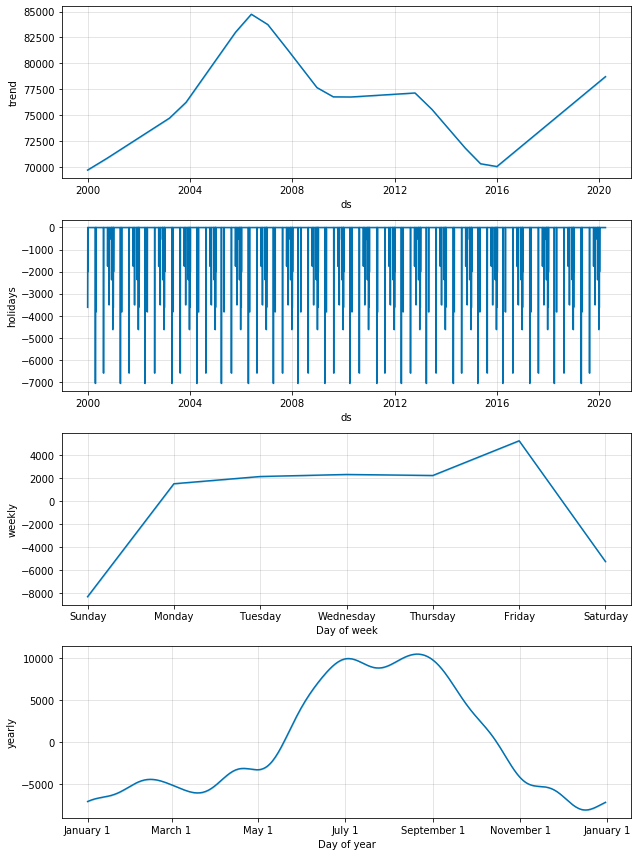

In [14]:
# Muestro en graficos los componentes que considera el modelo de predicciones: año, dia de la semana, dia del año
mod_prophet.plot_components(forecast)
plt.plot()

# Vemos que hay una tendencia anual, que puede relacionarse con campañas de concienciación, sequías y estrategias operativas
# Y tendencias semanalas y mensuales debidas principalmente a los hábitos del consumidor

[]

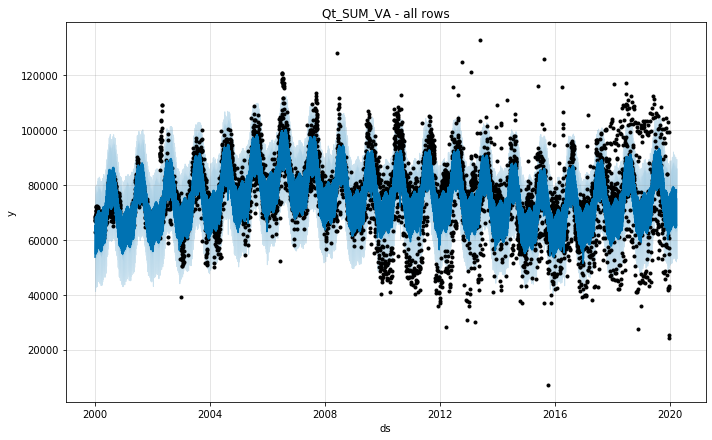

In [15]:
# Represento graficamente las predicciones de la tabla
mod_prophet.plot(forecast)
plt.title('Qt_SUM_VA - all rows');
plt.plot()

[]

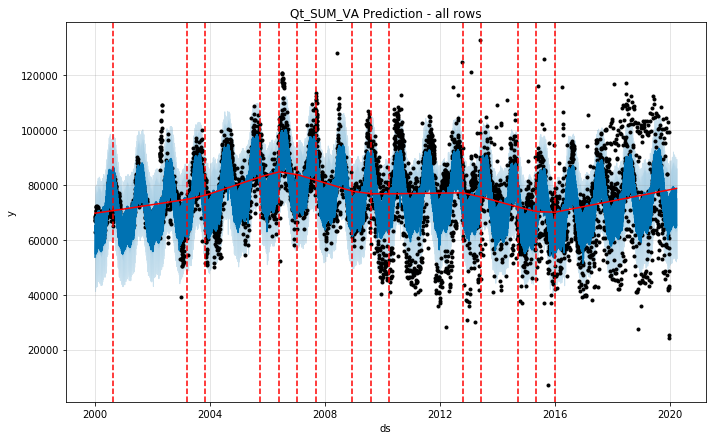

In [16]:
# Represento graficamente las predicciones, añadiendo los cambios de tendencia
from fbprophet.plot import add_changepoints_to_plot

fig=mod_prophet.plot(forecast)
a=a=add_changepoints_to_plot(fig.gca(), mod_prophet, forecast)
plt.title('Qt_SUM_VA Prediction - all rows');
plt.plot()

# Los cambios de tendencia por defecto se analizan en el 80% inicial de datos

## Comparacion de las predicciones con los registros reales

In [17]:
# Creo una nueva tabla con columnas para los pronosticos y los límites inferior y superior
cmp_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']]
cmp_df.head()

,yhat,yhat_lower,yhat_upper
ds,,,
2000-01-01,53690.830725,41349.279058,64339.111917
2000-01-02,54336.779862,41938.677269,66041.523584
2000-01-03,64223.427024,52971.796053,76433.601630
2000-01-04,64920.875188,52662.209061,77141.090516
2000-01-05,65161.475478,53290.324946,76606.609533


In [18]:
# vinculo la nueva tabla con los datos originales y establezco como indice la fecha en la columna ds
cmp_df = cmp_df.join(pro_df.set_index('ds'))
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2000-01-01,53690.830725,41349.279058,64339.111917,62728.0
2000-01-02,54336.779862,41938.677269,66041.523584,67306.0
2000-01-03,64223.427024,52971.796053,76433.601630,66848.0
2000-01-04,64920.875188,52662.209061,77141.090516,67294.0
2000-01-05,65161.475478,53290.324946,76606.609533,68562.0


In [19]:
# Los ultimos 90 registros de esta tabla vinculada solamente tienen predicciones, no datos
cmp_df.tail(91)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-12-31,73146.829556,61787.539996,85071.440132,42602.0
2020-01-01,69791.844308,57569.220389,81878.601362,NaN
2020-01-02,73403.336480,61548.844693,84207.279735,NaN
2020-01-03,76493.733610,64717.439095,88900.664258,NaN
2020-01-04,66075.052206,54736.042248,77344.373670,NaN
...,...,...,...,...
2020-03-26,75149.868319,63505.066780,87996.600935,NaN
2020-03-27,78256.422689,65850.163205,89475.380664,NaN
2020-03-28,67871.162004,55510.773305,79642.583071,NaN


[]

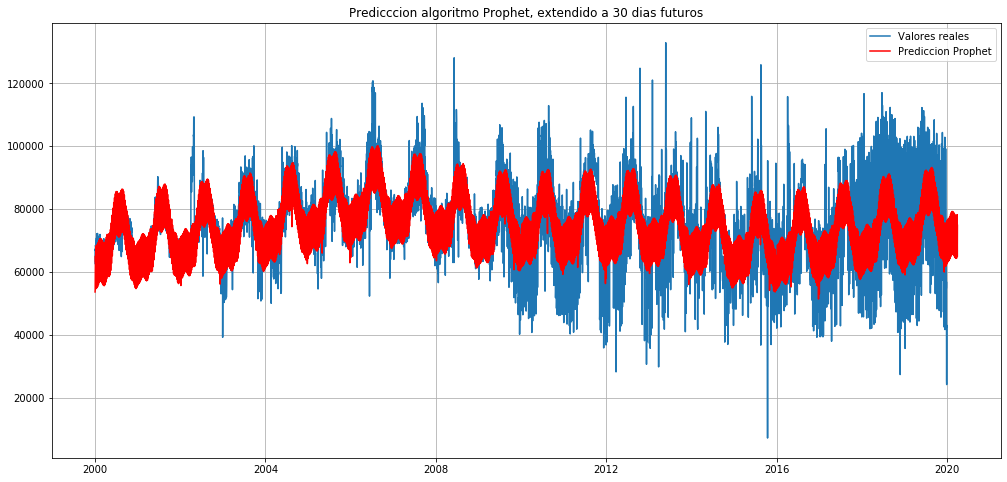

In [20]:
# Visualizo los datos originales y el valor predicho "yhat" para cada dia
plt.figure(figsize=(17,8))
plt.title("Predicccion algoritmo Prophet, extendido a 30 dias futuros")

# plt.plot(cmp_df['yhat_lower'])
# plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'], label="Valores reales")
plt.plot(cmp_df['yhat'], "red", label="Prediccion Prophet")

# Coloco leyenda e incluyo rejilla
plt.legend(loc="upper right")
plt.grid(True)

# plt.show()
plt.plot()

In [21]:
# La prediccion usando solo los parametros temporales de Prophet no incorpora otras consideraciones fuera de las fechas
# Esto se ve mejor si graficamos con detalle solo un periodo reducido. Con una función auxiliar
def plot_price_forecast(df,start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the actual and forecast data.
    
    Assumption: 
    - The dataframe has to be indexed on a Datetime column
    This makes the filtering very easy in pandas using df.loc
    """
    cmp_df = df.loc[start_date:end_date]
    plt.figure(figsize=(17,8))
    plt.title("Predicccion algoritmo Prophet para un periodo dado")
    
    plt.plot(cmp_df['y'], label="Valores reales")
    plt.plot(cmp_df['yhat'], "red", label="Prediccion Prophet")
    
    # Coloco leyenda e incluyo rejilla
    plt.legend(loc="upper right")
    plt.grid(True)
    
    # plt.legend()
    plt.plot()


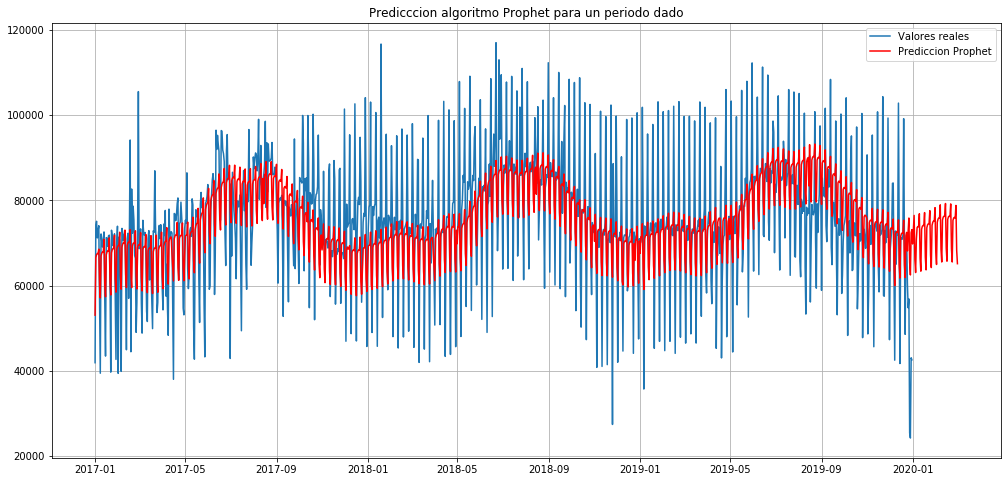

In [22]:
# Uso la funcion para representar entre fechas
plot_price_forecast(cmp_df,'2017-01-01','2020-03-01')

In [23]:
# Otra forma de mostrar solo las ultimas predicciones es con dataframe auxiliar
solo_pred_df = forecast.iloc[-90:,]
solo_pred_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen,Asunción de la Virgen_lower,Asunción de la Virgen_upper,Año nuevo,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
7305,2020-01-01,78215.736667,57569.220389,81878.601362,78215.736667,78215.736667,0.0,0.0,0.0,-3618.254067,...,2332.288691,2332.288691,2332.288691,-7137.926983,-7137.926983,-7137.926983,0.0,0.0,0.0,69791.844308
7306,2020-01-02,78221.344144,61548.844693,84207.279735,78221.344144,78221.344144,0.0,0.0,0.0,0.000000,...,2243.806105,2243.806105,2243.806105,-7061.813769,-7061.813769,-7061.813769,0.0,0.0,0.0,73403.336480
7307,2020-01-03,78226.951620,64717.439095,88900.664258,78226.951620,78226.951620,0.0,0.0,0.0,0.000000,...,5257.682157,5257.682157,5257.682157,-6990.900167,-6990.900167,-6990.900167,0.0,0.0,0.0,76493.733610
7308,2020-01-04,78232.559097,54736.042248,77344.373670,78232.559097,78232.559097,0.0,0.0,0.0,0.000000,...,-5231.920413,-5231.920413,-5231.920413,-6925.586478,-6925.586478,-6925.586478,0.0,0.0,0.0,66075.052206
7309,2020-01-05,78238.166573,51024.139698,75037.205981,78238.166573,78238.166573,0.0,0.0,0.0,0.000000,...,-8284.412301,-8284.412301,-8284.412301,-6866.040378,-6866.040378,-6866.040378,0.0,0.0,0.0,63087.713895


[]

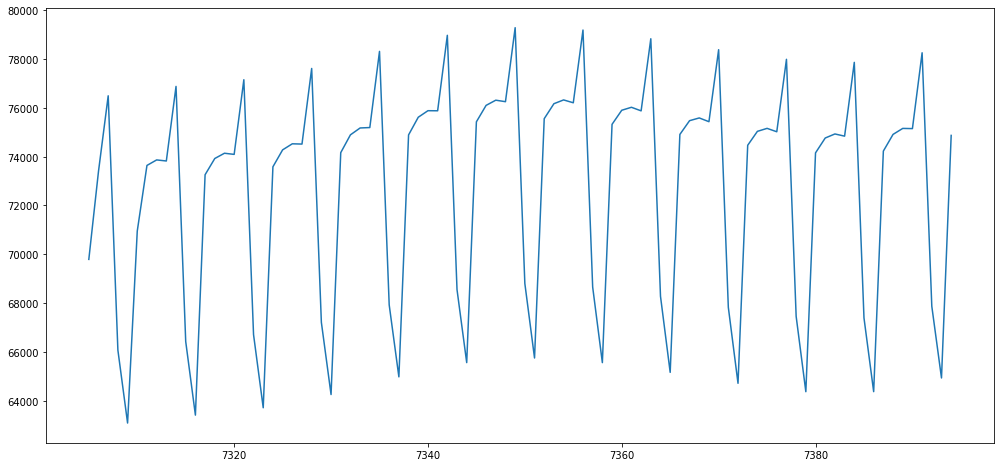

In [24]:
# Visualizo los datos originales y el valor predicho "yhat" para cada dia
plt.figure(figsize=(17,8))
plt.plot(solo_pred_df['yhat'])
plt.plot()

## Modelo Prophet con calendario propio, para fiestas locales

In [25]:
# Cargo funciones para generar festivos y calendarios
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay

# Defino una clase a partir de la clase AbastractHolidayCalendar para calendarios de vacaciones
# Uso con reglas para considerar festivos, y trasladar algunos de los domingos al lunes
# La seemana santa se calcula en función de la Pascua
class ES_VA_BusinessCalendar(AbstractHolidayCalendar):
   rules = [
     Holiday('Año Nuevo', month=1, day=1, observance=sunday_to_monday),
     Holiday('Epifanía del Señor', month=1, day=6, observance=sunday_to_monday),
     # Ojo, Jueves Santos festivos durante vigencia acuerdo Santa Sede de 1979 (art III)  
     Holiday('Viernes Santo', month=1, day=1, offset=[Easter(), Day(-2)]),
     Holiday('Día Castilla y León', month=4, day=23, observance=sunday_to_monday),  
     # Ojo, el 23 de abril se instituyo a partir del estatuto de autonomia en 1983
     Holiday('Día del Trabajo', month=5, day=1, observance=sunday_to_monday),
     Holiday('San Pedro Regalado', month=5, day=13, observance=sunday_to_monday),
     # Ojo, Corpus Christi (60 dias desde Pascua) festivos durante vigencia acuerdo Santa Sede de 1979 (art III)
     # Ojo, el 18 de julio fué festivo desde 1937 hasta 1978
     # Ojo el 25 de julio fué festivo desde 1937 hasta vigencia acuerdo Santa Sede de 1979 (articulo III)
     Holiday('Asunción de la Virgen', month=8, day=15, observance=sunday_to_monday),
     Holiday('Ntra Sra de San Lorenzo', month=9, day=13, observance=sunday_to_monday),
     # Ojo, hasta el año 2000 el festivo era San Mateo, el 21 septiembre 
     Holiday('Día de la Hispanidad', month=10, day=12, observance=sunday_to_monday),
     Holiday('Todos los Santos', month=11, day=1, observance=sunday_to_monday),
     Holiday('Día Constitución', month=12, day=6, observance=sunday_to_monday),
     Holiday('Inmaculada Concepción', month=12, day=8, observance=sunday_to_monday),  
     Holiday('Navidad', month=12, day=25, observance=sunday_to_monday)
   ]

# Defino función para crear el calendario de dias festivos con la clase anterior
Valladolid_fest = ES_VA_BusinessCalendar()

# Creo una serie de dias festivos con el rango de fechas que necesito
serieVA = Valladolid_fest.holidays(datetime(2000, 1, 1), datetime(2019, 12, 31))

# Genero el dataframe con fechas de festivos locales
fiestasVA_df = pd.DataFrame(serieVA, columns=['ds'])

# Adecuo al formato para Prophet con columna indicativa (por si uso otros datasets)
fiestasVA_df.insert(0,'holiday', 'festivos_VA')

fiestasVA_df.head()


,holiday,ds
0,festivos_VA,2000-01-01
1,festivos_VA,2000-01-06
2,festivos_VA,2000-04-21
3,festivos_VA,2000-04-24
4,festivos_VA,2000-05-01


In [26]:
# Persisto estes dataset
# Opto por csv para maxima compatibilidad y buen rendimiento, aunque inferior a msgpack (JSON binario o pockle-p2)
fiestasVA_df.to_csv("./fiestasVA_df.csv")

fiestasVA_df.tail()

,holiday,ds
255,festivos_VA,2019-10-12
256,festivos_VA,2019-11-01
257,festivos_VA,2019-12-06
258,festivos_VA,2019-12-09
259,festivos_VA,2019-12-25


In [27]:
# Defino un nuevo modelo con el parametro holidays, que indica el datset de puntos de cambio
mod_prophet_calVA = Prophet(interval_width=0.95, daily_seasonality=False, holidays = fiestasVA_df)

In [28]:
# Inicia cronometro
start_time = time.time()

# Entreno el modelo de predicción Prophet
mod_prophet_calVA.fit(pro_df)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("El entrenamiento del modelo Prophet tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")

El entrenamiento del modelo Prophet tarda:  12.76 segundos ( 0.2 minutos)


In [29]:
# Inicia cronometro
start_time = time.time()

# Realizo las predicciones con el modelo de prediccion para el marco de datos
forecast_calVA = mod_prophet_calVA.predict(future)

# Detiene el cronometro
end_time = time.time()

# Informa cronometro
dt = round(end_time - start_time, 2)
print("La predicción con el modelo Prophet tarda: ", dt, "segundos (", round(dt/60,1) , "minutos)")

La predicción con el modelo Prophet tarda:  3.36 segundos ( 0.1 minutos)


In [30]:
# Compruebo los efectos de cada tipo de evento en las predicciones
forecast_calVA[(forecast_calVA['festivos_VA']).abs() > 0][['ds', 'festivos_VA']][-10:]

# Vemos el impacto general de los festivos. Podria ser mas interesante diferenciar mas categorias (locales, nacionales, alfoz)

,ds,festivos_VA
7052,2019-04-23,-3107.088608
7060,2019-05-01,-3107.088608
7072,2019-05-13,-3107.088608
7166,2019-08-15,-3107.088608
7195,2019-09-13,-3107.088608
7224,2019-10-12,-3107.088608
7244,2019-11-01,-3107.088608
7279,2019-12-06,-3107.088608
7282,2019-12-09,-3107.088608
7298,2019-12-25,-3107.088608


[]

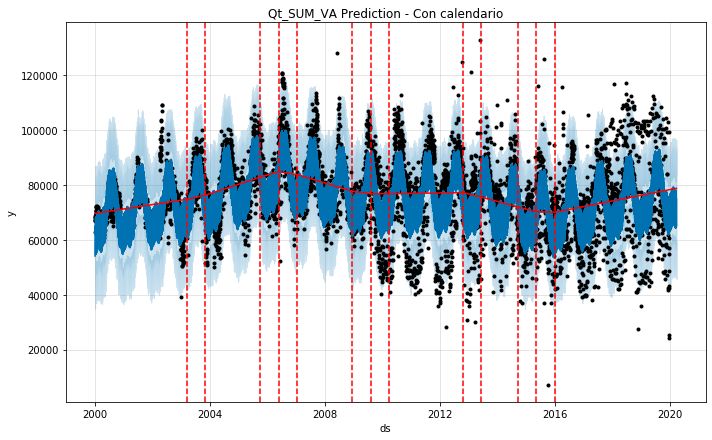

In [31]:
# Represento el modelo con los puntos de corte
fig=mod_prophet_calVA.plot(forecast_calVA)
a=a=add_changepoints_to_plot(fig.gca(), mod_prophet_calVA, forecast_calVA)
plt.title('Qt_SUM_VA Prediction - Con calendario');
plt.plot()

# Los cambios de tendencia por defecto se analizan en el 80% inicial de datos
# El modelo fuerza mas los cambios de tendencia en las fechas de los festivos

[]

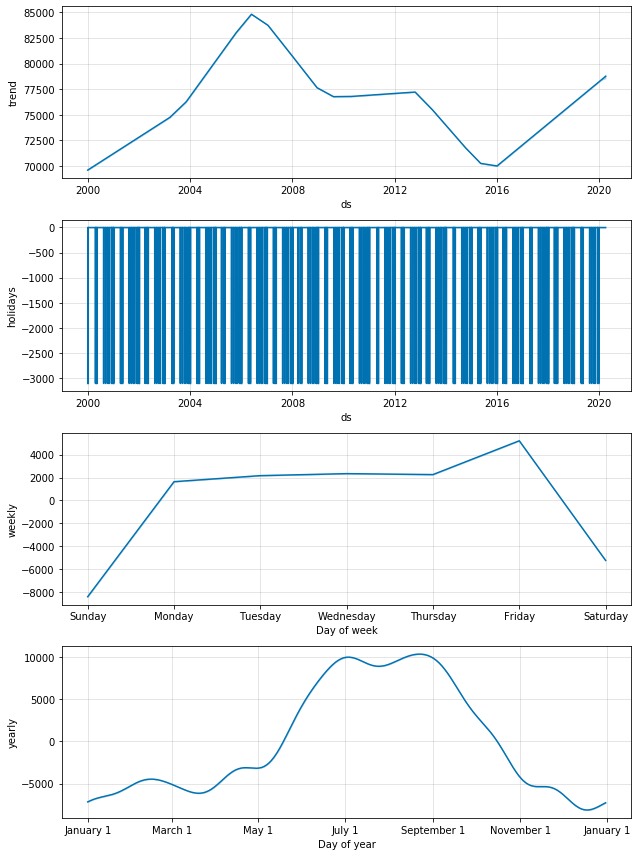

In [32]:
# En el grqafico de componentes tambien se aprecia la influencia de los eventos del calendario
mod_prophet_calVA.plot_components(forecast_calVA)
plt.plot()